# Определение стоимости автомобилей

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print('')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель исследования:**
- Построить модель машинного обучения для определения рыночной стоимости автомобиля. 

**Заказчику важны:**
- Качество предсказания: значение метрики **RMSE** должно быть **меньше 2500**;
- Время обучения модели;
- Скорость предсказания целевой переменной;


**Ход исследования:**
- Загрузка и обзор предоставленных данных;
- Предобработка данных;
- Подготовка признаков для обучения модели;
- Обучение моделей с различными гиперпараметрами;
- Анализ моделей, выбор лучшей;
- Тестирование отобранной модели на тестовой выборке;
- Финальный вывод.


## Загрузка и обзор данных

In [2]:
!pip install fast_ml 
!pip install Catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Импортируем необходимые для работы библиотеки и функции
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from fast_ml.model_development import train_valid_test_split
from sklearn.compose import make_column_transformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.metrics import mean_squared_error, r2_score

#настройки
warnings.filterwarnings('ignore')

#константы
RANDOM_STATE = 37

**Ознакомимся с данными.** Выведем на экран общую информацию, числовое описание данных, первые 5 строк:

In [4]:
# Прочитаем файл и сохраним его в переменной df
try:
    df = pd.read_csv('/content/drive/MyDrive/datasets/project_11/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')
# Получим общую информацию о таблице
df.info()
# Выведем на экран первые 5 строк таблицы
display(df.head(5))
# Получим числовое описание данных в таблице
display(df.describe())
# Проверка на дубликаты
print(f'Количество дубликатов в данных: {df.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество дубликатов в данных: 4


**Изучим документацию к данным:**

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

**Первые выводы:**

- Нам предоставлены "сырые" данные о 354 тысячах объявлений о продаже авто;
- У каждого объекта 15 признаков и 1 целевой признак - стоимость авто;
- Среди признаков есть неинформативные: почтовый индекс пользователя, дата последней активности, дата скачивания анкеты из базы, количество фотографий авто. Перед построением моделей мы их исключим.
- В данных присутствуют пропуски, а также уже видны аномальные значения (минимальный и максимальный год регистрации авто), есть дубликаты. 

На следующем шаге мы обработаем данные, прежде чем передавать их моделям машинного обучения.

## Предобработка данных

В первую очередь, **исправим нарушение стиля в заголовках**: поменяем CamelCase на snake_case.

In [5]:
# Создадим функцию, которая конвертирует стиль заголовка
def convert_to_snake_case(column):
    return ''.join(
        ['_' + i if i.isupper() else i for i in column]
        ).lstrip('_').lower()
df.columns = [convert_to_snake_case(c) for c in df.columns]

# Для проверки выведем названия колонок на экран
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

**Удалим явные дубликаты** в данных:

In [6]:
df = df.drop_duplicates().reset_index(drop=True)

Теперь **исключим признаки, которые не содержат никакой информации, которая помогла бы определить стоимость авто**: почтовый индекс пользователя, дата последней активности, дата скачивания анкеты из базы. Дата создания анкеты также не потребуется нам при построении модели, но она нужна нам для проверки на аномалии, поэтому мы исключим её чуть позже.    
Признак "количество фотографий автомобиля" полностью нулевой, поэтому мы также исключим эту колонку. 

In [7]:
df = df.drop({
    'date_crawled', 
    'number_of_pictures', 
    'postal_code', 
    'last_seen'
    }, axis=1)

Теперь **посчитаем количество пропущенных значений в данных**:

In [8]:
df.isna().sum()

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
dtype: int64

Пропуски присутствуют в 5 признаках, все они -- категориальные.  

Далее мы рассмотрим **каждый признак** на наличие пропусков, выбросов и аномалий, очистим данные перед обучением моделей.

### Цена

<function matplotlib.pyplot.show(close=None, block=None)>

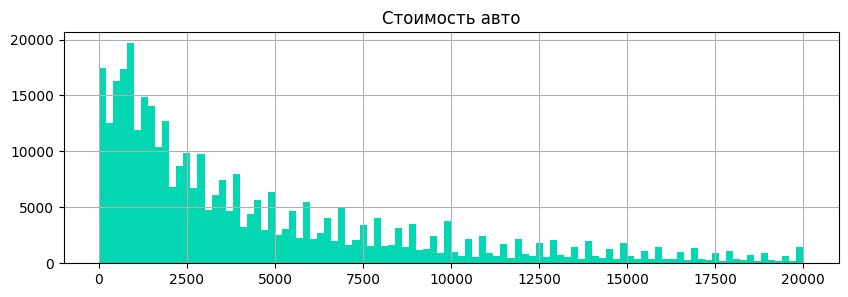

In [9]:
plt.figure(figsize=(10, 3))
plt.hist(df['price'], bins=100, color='#04d8b2')
plt.grid()
plt.title('Стоимость авто') 
plt.show

In [10]:
print(f'Количество объявлений с нулевой стоимостью: {len(df[df["price"] == 0])}')

Количество объявлений с нулевой стоимостью: 10772


Стоимость автомобилей в предоставленных данных распределяется от 0 до 20 000 евро. Верхняя планка цены вполне реалистична, но количество автомобилей со стоимостью от 0 до 500 евро настораживает. Возможно, это неисправные автомобили, которые продают на запчасти, либо условия сделки подразумевают договор о цене автомобиля на месте (например, в случае обмена на другой автомобиль с доплатой).   
Мы исключим из выборки автомобили с нулевой стоимостью, а также стоимостью ниже 100 евро, так как даже на запчасти авто не отдаётся даром. 

In [11]:
df = df[df['price'] >= 100]

### Год и месяц регистрации авто

<function matplotlib.pyplot.show(close=None, block=None)>

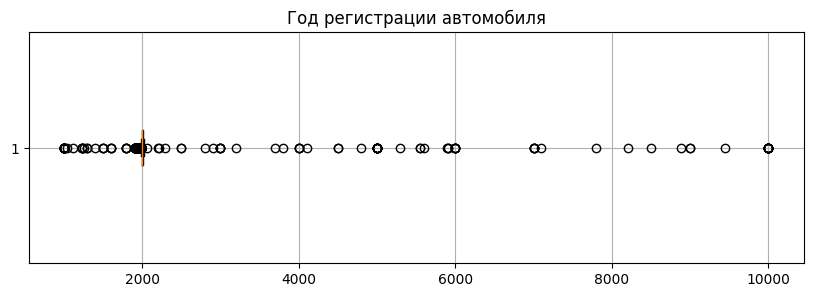

In [12]:
plt.figure(figsize=(10, 3))
plt.boxplot(df['registration_year'], vert=False)
plt.grid()
plt.title('Год регистрации автомобиля') 
plt.show

In [13]:
df.loc[(df['registration_year'] < 1910) | (df['registration_year'] > 2016)]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00
48,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00
51,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00
57,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
354108,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11 00:00:00
354136,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29 00:00:00
354199,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17 00:00:00
354249,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25 00:00:00


In [14]:
f"Процент аномальных значений года регистрации {len(df.loc[(df['registration_year'] < 1910) | (df['registration_year'] > 2016)]) / len(df):0.1%}"

'Процент аномальных значений года регистрации 4.0%'

В данных присутствуют аномалии: есть объявления о продаже авто, зарегестрированных до начала прошлого столетия (массовое производство автомобилей началось примерно в 10-е годы 20 века), или после года заполнения анкеты (2016 год). К сожалению, нам неизвестна природа этих аномалий. Так как процент таких значений небольшой, мы их исключим.

In [15]:
df = df.loc[(df['registration_year'] > 1910) & (df['registration_year'] < 2016)]

<function matplotlib.pyplot.show(close=None, block=None)>

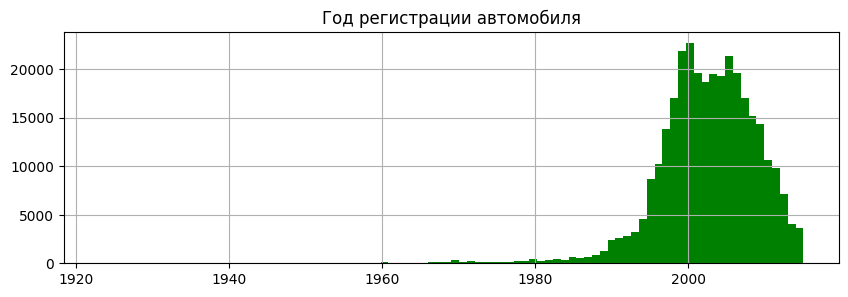

In [16]:
plt.figure(figsize=(10, 3))
plt.hist(df['registration_year'], bins=90, color='g')
plt.grid()
plt.title('Год регистрации автомобиля') 
plt.show

Удалим признак даты создания анкеты, он нам больше не пригодится.

In [17]:
df = df.drop('date_created', axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

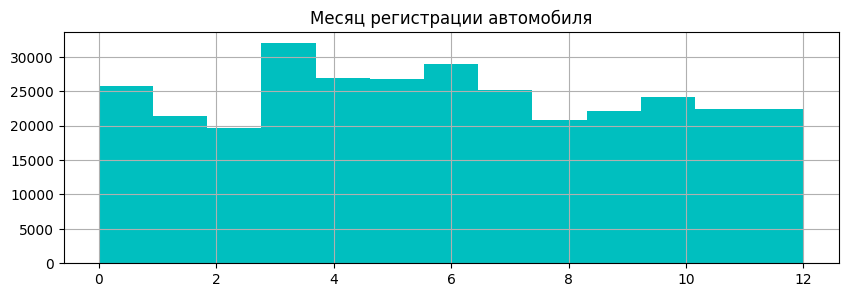

In [18]:
plt.figure(figsize=(10, 3))
plt.hist(df['registration_month'], bins=13, color='c')
plt.grid()
plt.title('Месяц регистрации автомобиля') 
plt.show

Среди значений **месяца регистрации автомобиля** есть 0 месяц, причем количество объектов с таким значением достаточно большое. Так как месяц регистрации автомобиля слабо влияет на его стоимость, мы **полностью исключим этот признак**. 

In [19]:
df = df.drop('registration_month', axis=1)

### Бренд и модель авто

<function matplotlib.pyplot.show(close=None, block=None)>

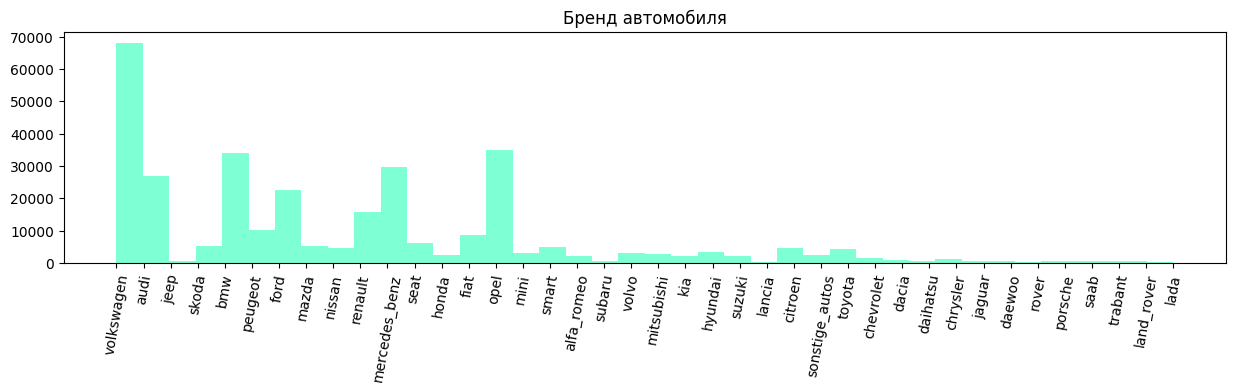

In [20]:
plt.figure(figsize=(15, 3))
plt.hist(df['brand'], bins=40, color='aquamarine')
plt.xticks(rotation=80)
plt.title('Бренд автомобиля') 
plt.show

Самый популярный **бренд** в нашей выборке - Volkswagen, а Opel на 2 месте. Аномалий нет.

Рассмотрим поближе объекты с пропущенными значениями признака "**модель** авто".  

In [21]:
df[df['model'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
81,350,small,1997,manual,54,NaN,150000,NaN,fiat,yes
135,1450,sedan,1992,manual,136,NaN,150000,NaN,audi,no
151,6799,small,2009,NaN,60,NaN,20000,petrol,volkswagen,no
160,500,small,1999,manual,0,NaN,150000,petrol,renault,no
...,...,...,...,...,...,...,...,...,...,...
354241,560,small,2001,auto,170,NaN,90000,petrol,fiat,yes
354317,9400,wagon,2007,manual,200,NaN,150000,gasoline,sonstige_autos,yes
354334,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN
354347,1900,NaN,2000,manual,110,NaN,150000,NaN,volkswagen,no


In [22]:
df[df['model'].isna()].isna().sum()

price                    0
vehicle_type          2213
registration_year        0
gearbox               2178
power                    0
model                13968
kilometer                0
fuel_type             3996
brand                    0
repaired              5681
dtype: int64

Этот признак будет играть значительную роль при построении модели, ведь стоимость автомобиля напрямую зависит от того, какой он модели и бренда.  
Мы видим, что в объектах с пропущенным значением модели также часто присутствуют пропуски в других признаках.  

Мы полностью исключим все объекты с пропущенным значением модели, чтобы избавиться от шума в данных.

In [23]:
df.dropna(subset=['model'], inplace=True)

### Мощность и пробег

<function matplotlib.pyplot.show(close=None, block=None)>

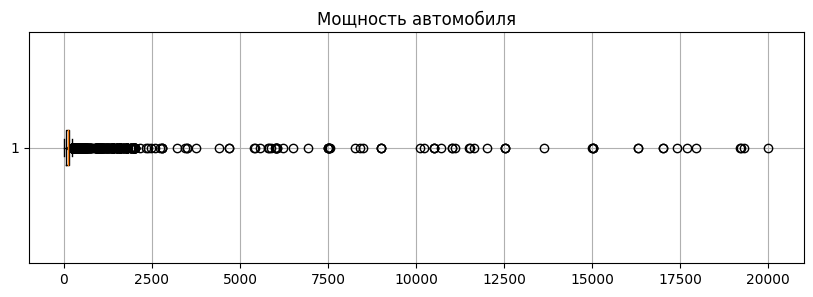

In [24]:
plt.figure(figsize=(10, 3))
plt.boxplot(df['power'], vert=False)
plt.grid()
plt.title('Мощность автомобиля') 
plt.show

In [25]:
df[df['power'] > 700]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,NaN
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
348664,1000,wagon,1996,manual,2598,a6,150000,NaN,audi,NaN
348879,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,NaN
348964,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351943,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no


In [26]:
df[df['power'] <= 30]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
54,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes
69,1200,coupe,2001,NaN,0,astra,150000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
354331,390,small,1997,auto,0,corsa,100000,petrol,opel,yes
354332,3299,NaN,2005,auto,0,outlander,150000,petrol,mitsubishi,NaN
354342,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354356,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no


На сегодняшний день **самым мощным** легковым автомобилем в мире назван Dagger GT компании TranStar Racing LLC. Мощность его двигателя составляет **2028** л.с. При этом в нашей выборке не представлены автомобили этого бренда.    
Мы возьмем за максимальное значение мощности автомобиля 700 лошадиных сил -- это больше, чем самый быстрый Alfa Romeo. Так как объектов, превышающих это значение, не много, мы их исключим.

Также в данных около **30 000 объектов с 0 мощностью двигателя**. Возможно, это автомобили не на ходу, без двигателя.  
У автомобиля Lada Ока мощность двигателя составляла всего 33 лошадиные силы. Мы возьмем за минимальное значение мощности 30 л.с. В нашей выборке чуть больще 31 тысячи объектов с значением мощности меньше минимального. Чтобы они не вредили нашей модели, мы также исключим их.

In [27]:
df = df[(df['power'] > 30) & (df['power'] < 700)]

<function matplotlib.pyplot.show(close=None, block=None)>

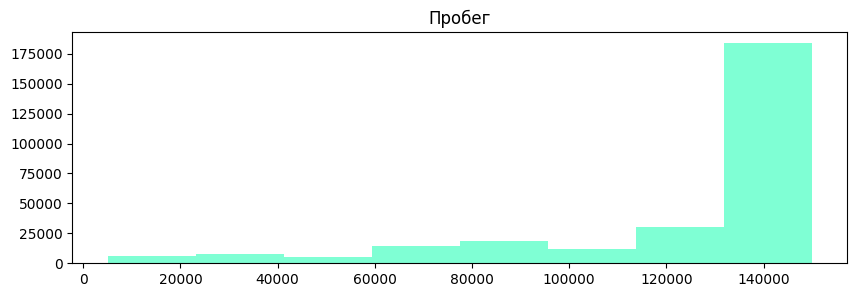

In [28]:
plt.figure(figsize=(10, 3))
plt.hist(df['kilometer'], bins=8, color='aquamarine')
plt.title('Пробег')
plt.show

Наиболее частое значение пробега - 150 тысяч километров, оно же и является максимальным значением. Мы можем предположить, что это максимальное значение пробега автомобиля, которое было предложено при заполнении анкеты. Здесь исключать ничего не нужно.

Проверим, сколько пропущенных значений осталось в датасете:

### Категориальные признаки

In [29]:
df.isna().sum()

price                    0
vehicle_type          3873
registration_year        0
gearbox               4154
power                    0
model                    0
kilometer                0
fuel_type            10524
brand                    0
repaired             36394
dtype: int64

К сожалению, у нас нет возможности восстановить оставщиеся пропущенные значения в столбцах. В данных нет зависимостей, которые можно было бы успешно использовать для этих признаков. Заполняя большие объемы пропусков медианой или модой, мы можем получить недостоверные данные, из-за чего качество нашей модели пострадает.

Мы **заменим все оставшиеся пропущенные значения на заглушку `unknown`**.

In [30]:
columns_to_replace = ['vehicle_type', 
                      'gearbox', 
                      'fuel_type', 
                      'repaired'] 

for columns in columns_to_replace:
    df[columns] = df[columns].fillna('unknown')

df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

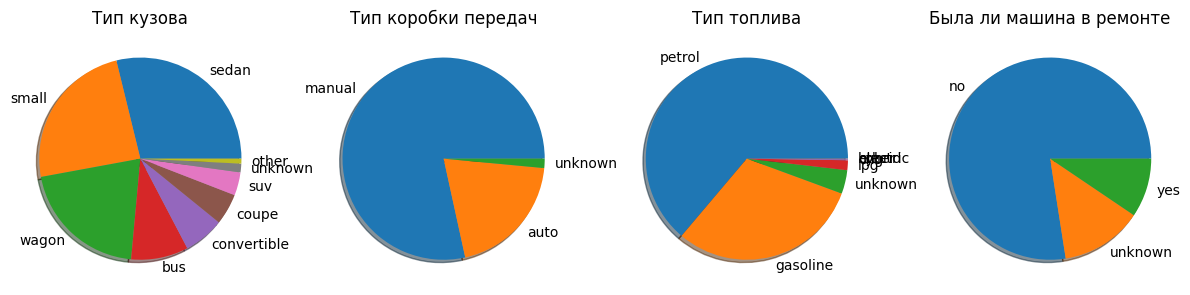

In [31]:
plt.figure(figsize=(15, 5))
plt.subplot (1, 4, 1)
plt.pie(x=df['vehicle_type'].value_counts(), 
        labels=df['vehicle_type'].value_counts().index, shadow=True)
plt.legend()
plt.title('Тип кузова')
plt.subplot (1, 4, 2)
plt.pie(x=df['gearbox'].value_counts(), 
        labels=df['gearbox'].value_counts().index, shadow=True)
plt.legend()
plt.title('Тип коробки передач')
plt.subplot (1, 4, 3)
plt.pie(x=df['fuel_type'].value_counts(), 
        labels=df['fuel_type'].value_counts().index, shadow=True)
plt.legend()
plt.title('Тип топлива')
plt.show
plt.subplot (1, 4, 4)
plt.pie(x=df['repaired'].value_counts(), 
        labels=df['repaired'].value_counts().index, shadow=True)
plt.legend()
plt.title('Была ли машина в ремонте')


plt.show

Среди категориальных признаков никаких аномалий не обнаружено.

In [32]:
# Выведем актуальную информацию о данных на экран
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278225 entries, 2 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              278225 non-null  int64 
 1   vehicle_type       278225 non-null  object
 2   registration_year  278225 non-null  int64 
 3   gearbox            278225 non-null  object
 4   power              278225 non-null  int64 
 5   model              278225 non-null  object
 6   kilometer          278225 non-null  int64 
 7   fuel_type          278225 non-null  object
 8   brand              278225 non-null  object
 9   repaired           278225 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.3+ MB


**В ходе предобработки данных мы:**
- Заменили или исключили пропущенные значения
- Избавились от аномалий 
- Исключили дубликаты
- Исключили неинформативные признаки

Мы потеряли более 20% объектов от "сырой" выборки, но качество данных стало значительно выше, что очень важно для построения моделей.

На следующем этапы мы подготовим выборки для обучения моделей.

## Подготовка выборки для обучения моделей

Разделим данные на тренировочную, валидационную и тестовую выборки.


In [33]:
# Разделим данные на обучающую, валидационную и тестовую выборки
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(
     df, 'price', 
     train_size=0.7, valid_size=0.15, test_size=0.15, 
     random_state=RANDOM_STATE
     )

**Закодируем данные.**   
В нашей работе мы будем проверять модели: 
- Линейной регрессии;
- Дерево решений;
- Случайный лес;
- Градиентный бустинг.

Для модели линейной регрессии мы закодируем категориальные признаки методом `OneHotEncoder`, для деревьев -- `OrdinalEncoder`, а для модели бустинга мы будем использовать встроенный способ. Все численные признаки мы закодируем с помощью `StandarScaler`.

Для начала, создадим переменные для категориальных и численных признаков.



In [34]:
# Создадим переменные для категориальных и численных признаков
cat_columns = [
    'vehicle_type', 'gearbox', 'fuel_type', 
    'brand', 'model', 'repaired'
    ]
num_columns = [
    'kilometer', 'power',
    'registration_year'
    ]

Создадим два трансформера: в первом с кодировка категориальных признаков будет осуществляться методом **OneHotEncoder** во втором -- **OrdinalEncoder**. Оба трансформера также будут масштабировать численные признаки методом StandarScaler

In [35]:
# Создаем трансформеры с помощью make_column_transformer
ohe_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        cat_columns
    ),
    (
        StandardScaler(), 
        num_columns
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

ordinal_transformer = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        cat_columns
    ),
    (
        StandardScaler(), 
        num_columns
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

Данные распределены на обучающую, валидационную и тестовую выборки, трансформеры для масштабирования и кодирования признаков созданы. Можем переходить к обучению моделей.

## Обучение моделей

Отбор наилучшей модели будет происходить в несколько этапов:

- На обучающей выборке для каждой модели мы подберем оптимальные гиперпараметры кросс-валидацией с помощью RandomizedSearch.
- Затем мы измерим скорость обучения модели с оптимальными гиперпараметрами на всей тренировочной выборке. 
- Затем мы зафиксируем скорость предсказания на валидационной выборке.

После этого мы перейдем к этапу анализа моделей: в общей таблице мы рассмотрим следующие показатели каждой модели:
- Время обучения, 
- Время предсказания, 
- RMSE модели, 
- R2 score модели.

На основе этих данных мы отберем наилучшую модель, которую проверим на тестовой выборке.


В данном исследвании мы обучим следующие модели:
1. Линейные модели:
  - Linear Regression
  - Ridge
2. Decision Tree Regressor
3. Random Forest Regressor
4. Градиентный бустинг:

  - LightGBM Regressor
  - CatBoost Regressor

Подбор гиперпараметров мы будем производить кросс-валидацией с помощью RandomizedSearch + Pipeline. Для этого создадим функцию, которая будет принимать на вход pipeline с моделью и трансформером, а также набор гиперпараметров, а возвращать гиперпараметры лучшей модели и наилучшее значение метрики **RMSE** на обучающей выборке.

In [36]:
def best_model_and_score(pipe, params):
    rs_pl = RandomizedSearchCV(
        pipe, 
        param_distributions=params, 
        scoring='neg_root_mean_squared_error',
        n_iter=15, cv=3, random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rs_pl.fit(X_train, y_train)
 
    # лучшее значение RMSE на кросс-валидации
    print(f'best_score_AUC: {rs_pl.best_score_:0.4f}')
    # лучшие гиперпараметры
    print(f'best_params: { rs_pl.best_params_}')
    
    return rs_pl.best_estimator_

### Линейная регрессия

Найдем наилучшие гиперпараметры для линейных моделей Ridge и Linear Regression на данных, трансформированных методом OHE, после чего зафиксируем время обучения и время предсказания моделей.

#### Ridge

In [37]:
# Подберем гиперпараметры для модели Ridge на трансформере OHE
model_ridge = Ridge(random_state=RANDOM_STATE)
pipe_ridge = make_pipeline(ohe_transformer, model_ridge)
param_ridge = {
    'ridge__alpha': np.arange(0, 2.0, 0.1),
    'ridge__solver': [
        'auto', 'svd', 'cholesky', 'lsqr', 
        'sparse_cg', 'sag', 'saga', 'lbfgs'
        ]
}

best_ridge_model = best_model_and_score(
    pipe_ridge, param_ridge
)

best_score_AUC: -2481.5695
best_params: {'ridge__solver': 'auto', 'ridge__alpha': 1.2000000000000002}


In [38]:
# Зафиксируем время обучения
%%time
start = time.time()
best_ridge_model.fit(X_train, y_train)
end = time.time()
ridge_train_time=round(end-start,2)

CPU times: user 2.06 s, sys: 1.24 s, total: 3.3 s
Wall time: 1.94 s


In [39]:
# Предскажем значения целевого признака на валидационной выборке, 
# Зафиксируем время предсказания,
# Вычислим метрики RMSE и R2 модели
%%time
start = time.time()
ridge_predictions = best_ridge_model.predict(X_valid)
end = time.time()
ridge_predict_time=round(end-start,2)

ridge_rmse = mean_squared_error(ridge_predictions, y_valid, squared=False)
ridge_r2 = r2_score(y_valid, ridge_predictions)

CPU times: user 146 ms, sys: 84.7 ms, total: 231 ms
Wall time: 158 ms


#### Linear Regression

In [40]:
# Подберем гиперпараметры для модели линейной регрессии на трансформере OHE
model_lr = LinearRegression()
pipe_lr = make_pipeline(ohe_transformer, model_lr)
param_lr = {
    'linearregression__fit_intercept':[True,False], 
    'linearregression__copy_X':[True, False]
}

best_lr_model = best_model_and_score(
    pipe_lr, param_lr
)

best_score_AUC: -2481.4063
best_params: {'linearregression__fit_intercept': True, 'linearregression__copy_X': True}


In [41]:
# Зафиксируем время обучения
%%time
start = time.time()
best_lr_model.fit(X_train, y_train)
end = time.time()
lr_train_time=round(end-start,2)

CPU times: user 5.2 s, sys: 3.76 s, total: 8.96 s
Wall time: 5.55 s


In [42]:
# Предскажем значения целевого признака на валидационной выборке, 
# Зафиксируем время предсказания,
# Вычислим метрики RMSE и R2 модели

%%time
start = time.time()
lr_predictions = best_lr_model.predict(X_valid)
end = time.time()
lr_predict_time=round(end-start,2)

lr_rmse = mean_squared_error(lr_predictions, y_valid, squared=False)
lr_r2 = r2_score(y_valid, lr_predictions)

CPU times: user 173 ms, sys: 79.7 ms, total: 253 ms
Wall time: 218 ms


### Дерево решений


In [43]:
# Подберем гиперпараметры для модели Дерево решений 
# На трансформере Ordinal Encoder

model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
pipe_dtr = make_pipeline(ordinal_transformer, model_dtr)
param_dtr = {
    'decisiontreeregressor__splitter': ['best', 'random'],
    'decisiontreeregressor__min_samples_split': range(1, 101, 5),
    'decisiontreeregressor__max_depth': [1, 5, 7, 10, 15, 20, 30, 40, None],
}

best_dtr_model = best_model_and_score(
    pipe_dtr, param_dtr
)

best_score_AUC: -1765.1516
best_params: {'decisiontreeregressor__splitter': 'best', 'decisiontreeregressor__min_samples_split': 26, 'decisiontreeregressor__max_depth': 40}


In [44]:
# Зафиксируем время обучения
%%time
start = time.time()
best_dtr_model.fit(X_train, y_train)
end = time.time()
dtr_train_time=round(end-start,2)

CPU times: user 1.57 s, sys: 125 µs, total: 1.57 s
Wall time: 1.63 s


In [45]:
# Предскажем значения целевого признака на валидационной выборке, 
# Зафиксируем время предсказания,
# Вычислим метрики RMSE и R2 модели

%%time
start = time.time()
dtr_predictions = best_dtr_model.predict(X_valid)
end = time.time()
dtr_predict_time=round(end-start,2)

dtr_rmse = mean_squared_error(dtr_predictions, y_valid, squared=False)
dtr_r2 = r2_score(y_valid, dtr_predictions)

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 146 ms


### Случайный лес

In [46]:
# Подберем оптимальные гиперпараметры для модели случайного леса 
# На трансформере Ordinal Encoder

model_rfr = RandomForestRegressor(random_state=RANDOM_STATE)
pipe_ord_rfr = make_pipeline(ordinal_transformer, model_rfr)

param_rfr = {
    'randomforestregressor__n_estimators': range(10, 151, 10),
    'randomforestregressor__max_depth': [None, 1, 3, 5, 7, 10, 13, 15, 17, 20],
    'randomforestregressor__min_samples_split': range(2, 11, 2),
    'randomforestregressor__min_samples_leaf': range(1, 13, 2),
    'randomforestregressor__max_features': ['auto', 'sqrt']
}

best_rfr_model = best_model_and_score(
    pipe_ord_rfr, param_rfr
)

best_score_AUC: -1578.5340
best_params: {'randomforestregressor__n_estimators': 80, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_depth': 20}


In [47]:
# Зафиксируем время обучения
%%time
start = time.time()
best_rfr_model.fit(X_train, y_train)
end = time.time()
rfr_train_time=round(end-start,2)

CPU times: user 15.6 s, sys: 88.3 ms, total: 15.7 s
Wall time: 15.7 s


In [48]:
# Предскажем значения целевого признака на валидационной выборке, 
# Зафиксируем время предсказания,
# Вычислим метрики RMSE и R2 модели

%%time
start = time.time()
rfr_predictions = best_rfr_model.predict(X_valid)
end = time.time()
rfr_predict_time=round(end-start,2)

rfr_rmse = mean_squared_error(rfr_predictions, y_valid, squared=False)
rfr_r2 = r2_score(y_valid, rfr_predictions)

CPU times: user 856 ms, sys: 175 µs, total: 856 ms
Wall time: 857 ms


### Градиентный бустинг

#### LightGBM

In [49]:
# Подберём оптимальные гиперпараметры для модели LightGBM на трансформере OHE
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
pipe_lgbm = make_pipeline(ohe_transformer, model_lgbm)
param_lgbm = {
    'lgbmregressor__max_depth': [1, 5, 10, 15, 20, None],
    'lgbmregressor__n_estimators': range(10, 301, 10)
}

best_lgbm_model = best_model_and_score(
    pipe_lgbm, param_lgbm
)

best_score_AUC: -1554.9640
best_params: {'lgbmregressor__n_estimators': 260, 'lgbmregressor__max_depth': None}


In [50]:
# Зафиксируем время обучения
%%time
start = time.time()
best_lgbm_model.fit(X_train, y_train)
end = time.time()
lgbm_train_time=round(end-start,2)

CPU times: user 9.45 s, sys: 81.4 ms, total: 9.53 s
Wall time: 6.86 s


In [51]:
# Предскажем значения целевого признака на валидационной выборке, 
# Зафиксируем время предсказания,
# Вычислим метрики RMSE и R2 модели

%%time
start = time.time()
lgbm_predictions = best_lgbm_model.predict(X_valid)
end = time.time()
lgbm_predict_time=round(end-start,2)

lgbm_rmse = mean_squared_error(lgbm_predictions, y_valid, squared=False)
lgbm_r2 = r2_score(y_valid, lgbm_predictions)

CPU times: user 986 ms, sys: 4.05 ms, total: 990 ms
Wall time: 560 ms


#### CatBoost
Обучим модель Градиентного бустинга CatBoost. Мы не будем кодировать данные и подбирать гиперпараметры -- в CatBoost есть встроенный метод кодировки данных.

In [52]:
# Зафиксируем время обучения
%%time
model_cbr = CatBoostRegressor(
    logging_level='Silent', 
    cat_features = cat_columns,
    random_state=RANDOM_STATE)
start = time.time()
model_cbr.fit(X_train, y_train)
end = time.time()
cbr_train_time=round(end-start,2)

CPU times: user 6min 19s, sys: 3.67 s, total: 6min 23s
Wall time: 3min 55s


In [53]:
# Предскажем значения целевого признака на валидационной выборке, 
# Зафиксируем время предсказания,
# Вычислим метрики RMSE и R2 модели

%%time
start = time.time()
cbr_predictions = model_cbr.predict(X_valid)
end = time.time()
cbr_predict_time=round(end-start,2)

cbr_rmse = mean_squared_error(cbr_predictions, y_valid, squared=False)
cbr_r2 = r2_score(y_valid, cbr_predictions)

CPU times: user 526 ms, sys: 2.78 ms, total: 529 ms
Wall time: 378 ms


## Анализ моделей

In [54]:
colm = [
    'Время обучения', 'Время предсказания', 
    'RMSE модели', 'R2 score модели'
    ] 
ind = [
    'Ridge', 'Linear Regression', 'Decision Tree Regressor', 
    'Random Forest Regressor', 'LightGBM Regressor', 'CatBoost Regressor'
    ]
val = [
    [ridge_train_time, ridge_predict_time, round(ridge_rmse, 2), round(ridge_r2, 2)], 
    [lr_train_time, lr_predict_time, round(lr_rmse, 2), round(lr_r2, 4)], 
    [dtr_train_time, dtr_predict_time, round(dtr_rmse, 2), round(dtr_r2, 4)], 
    [rfr_train_time, rfr_predict_time, round(rfr_rmse, 2), round(rfr_r2, 4)], 
    [lgbm_train_time, lgbm_predict_time, round(lgbm_rmse, 2), round(lgbm_r2, 4)], 
    [cbr_train_time, cbr_predict_time, round(cbr_rmse, 2), round(cbr_r2, 4)]
]

data_info = pd.DataFrame(data=val, index=ind, columns=colm)

data_info.sort_values('RMSE модели').style.background_gradient(axis=0, cmap='YlOrRd')

,Время обучения,Время предсказания,RMSE модели,R2 score модели
Random Forest Regressor,15.700000,0.850000,1544.690000,0.889400
CatBoost Regressor,235.940000,0.380000,1546.270000,0.889100
LightGBM Regressor,6.860000,0.560000,1549.820000,0.888600
Decision Tree Regressor,1.630000,0.140000,1725.120000,0.862000
Ridge,1.940000,0.160000,2525.640000,0.700000
Linear Regression,5.550000,0.220000,2525.770000,0.704200


Наилучшие значения метрики RMSE показали модели:
- `Random Forest Regressor`	
- `CatBoost Regressor`
- `LightGBM Regressor`

Линейные модели (`Ridge`, `Linear Regression`) показали одинаково плохой результат: обе модели превысили максимальное значение метрики, установленное заказчиком. Мы исключим эти модели из дальнейшего анализа. 

Модель `Decision Tree Regressor` показала неплохой результат, но значение метрики трёх лидирующих моделей значительно лучше, поэтому мы также исключаем эту модель из дальнейшего анализа. 

Изучим распределение истинных и предсказанных лидирующими моделями значений на графике, после чего произведем финальных анализ и выбор наилучшей модели.

In [59]:
print(y_valid.shape)
print(rfr_predictions.shape)

(41734,)
(41734,)


<function matplotlib.pyplot.show(close=None, block=None)>

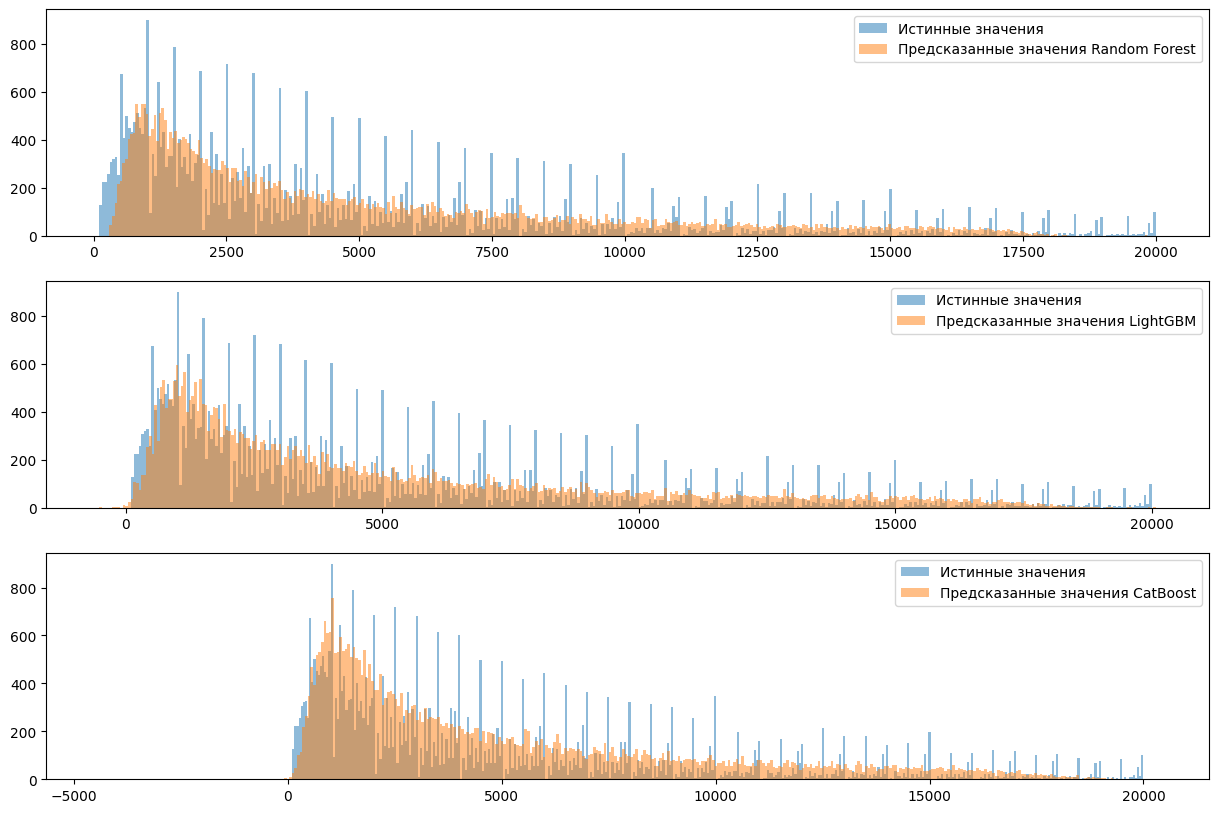

In [60]:
plt.figure(figsize=(15, 10))
plt.title('Распределение истинных и предсказанных значений')
plt.subplot (3, 1, 1)
plt.hist(y_valid, bins=400, alpha=0.5, label='Истинные значения')
plt.hist(rfr_predictions, bins=400, 
         alpha=0.5, label='Предсказанные значения Random Forest')
plt.legend()
plt.subplot (3, 1, 2)
plt.hist(y_valid, bins=400, alpha=0.5, label='Истинные значения')
plt.hist(lgbm_predictions, bins=400, 
         alpha=0.5, label='Предсказанные значения LightGBM')
plt.legend()
plt.subplot (3, 1, 3)
plt.hist(y_valid, bins=400, alpha=0.5, label='Истинные значения')
plt.hist(cbr_predictions, bins=400, 
         alpha=0.5, label='Предсказанные значения CatBoost')
plt.legend()
plt.show

**Градиентный бустинг CatBoost Regressor**
- Модель градиентного бустинга CatBoost показала неплохой результат по метрикам RMSE и R2, по этим параметрам она находится на 2 месте.
- Эта модель обучалась дольше, чем любая другая модель, которую мы проверяли в данном исследовании, время обучения составило **235 секунд**. 
- На графике распределения истинных и предсказанных значений мы видим, что модель CatBoost выдала несколько отрицательных предсказаний. Их не много, но выбросы значительно удалены от нуля.

**Случайный лес**  
- Модель Случайного леса показала наилучшие значения обеих метрик. 
- Обучалась модель быстрее, чем CatBoost, но дольше остальных моделей: 16 секунд. При этом время предсказания у данной модели самое большое.
- Визуально распределение предсказанных значений и истинных значений очень схоже. Предсказание отрицательных значений полностью отсутствует.

**Градиентный бустинг LightGBM Regressor**  
- Модель LGBMRegressor на метриках RMSE и R2 показала результат хуже, чем два предыдущих лидера, но отрыв совсем небольшой. 
- На обучение модели потребовалось немного меньше 7 секунд. Но по времени предсказания -- на 2 месте среди самых долгопредсказывающих.
- На графике распределения предсказанных и истинных значений мы также видим отрицательные значения среди предсказанных. Но их отбросило не так далеко, чем у CatBoost.

Так как главным показателем для нас и для заказчика все же является метрика качества предсказания, для финальной проверки на тестовой выборке мы отбираем модель **Случайного леса**. 

- Значение метрики **RMSE** лучшей модели: **1544.69**
- Значение метрики **R2** лучшей модели: **0.8894**
- Параметры модели: `{'n_estimators': 80 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 20}`


## Тестирование модели

Нам осталось совершить последний шаг нашего исследования -- проверить модель на тестовых данных.

Проанализировав результаты работы всех моделей на валидационной выборке, мы отобрали наилучшую модель по всем ключевым показателям -- модель **Случайный лес**.  
По заданию заказчика, метрика RMSE должа показать результат на тестовой выборке **не выше 2500 единиц**. В случае, если отобранная нами модель не превысит этот показатель, исследование можно считать успешным.

In [57]:
# Предскажем значения целевого признака на тестовой выборке, 
# Зафиксируем время предсказания,
# Вычислим метрики RMSE и R2 модели

%%time
start = time.time()
rfr_predictions = best_rfr_model.predict(X_test)
end = time.time()
rfr_predict_time=round(end-start,2)

rfr_rmse = mean_squared_error(rfr_predictions, y_test, squared=False)
rfr_r2 = r2_score(y_test, rfr_predictions)

CPU times: user 879 ms, sys: 1.88 ms, total: 881 ms
Wall time: 878 ms


In [58]:
print(f'''Время предсказания: {rfr_predict_time}.
Метрика RMSE модели на тестовых данных: {rfr_rmse:0.2f}.
Метрика R2 модели на тестовых данных: {rfr_r2:0.2f}''')

Время предсказания: 0.88.
Метрика RMSE модели на тестовых данных: 1552.72.
Метрика R2 модели на тестовых данных: 0.89


По результатам тестирования, отобранная нами модель показала хороший результат. Скорость предсказания оказалась быстрее, чем на валидационной выборке, а показатель основной метрики **RMSE** достиг значения **1552.72**, что значительно лучше порога, установленного заказчиком.


## Отчет по работе

В ходе нашего исследования мы проделали следующие шаги:

### 1. Загрузили и изучили предоставленные данные.
Прочитали предоставленный файл, сохранили его в переменной `df`, после чего изучили данные:

- Получили общую информацию о таблице;
- Вывели на экран первые 5 строк таблицы;
- Получили числовое описание данных в таблице.
- Проверили данные на дубликаты
- Изучили документацию к данным

В ходе первичного обзора данных мы сделали следующие первые выводы:

- Нам предоставлены "сырые" данные о 354 тысячах объявлений о продаже авто;
- У каждого объекта 15 признаков и 1 целевой признак - стоимость авто;
- Среди признаков есть неинформативные: почтовый индекс пользователя, дата последней активности, дата скачивания анкеты из базы, количество фотографий авто. 
- В данных присутствуют пропуски, а также уже видны аномальные значения (минимальный и максимальный год регистрации авто), есть дубликаты.

### 2. Произвели предобработку данных

- Изменили наименования колонок, согласно правилам хорошего стиля;
- Удалили явные дубликаты в данных;
- Исключили признаки, которые не содержат никакой информации, которая помогла бы определить стоимость авто: почтовый индекс пользователя, дата последней активности, дата скачивания анкеты из базы. Дата создания анкеты также не потребуется нам при построении модели, но она нужна нам для проверки на аномалии, поэтому мы исключили её чуть позже.
Признак "количество фотографий автомобиля" полностью нулевой, поэтому мы также исключили эту колонку.
- Посчитаем количество пропущенных значений в данных: они присутствуют в 5 признаках, все они -- категориальные. 

Далее мы изучили каждый из признаков по отдельности на наличие пропусков, выбросов и аномалий, очистили данные перед обучением моделей.
- Исключили из выборки все автомобили с нулевой стоимостью, а также стоимостью ниже 100 евро;
- Исключили строки с аномальным значением даты регистрации авто: зарегестрированных до начала прошлого столетия (массовое производство автомобилей началось примерно в 10-е годы 20 века), или после года заполнения анкеты (2016 год). Так как нам неизвестна природа этих аномалий, и их количество составляет всего 4% от датасета, мы их исключили.
- Полностью исключили признак значения месяца регистрации авто, так как в нем было достаточно много аномальных значений (0 месяц).
- Полностью исключили все объекты с пропущенным значением модели, чтобы избавиться от шума в данных.
- Исключили объекты с аномальными значениями мощности автомобиля: оставили только те, в которых значение этого признака не меньше 30 и не больше 700.

На этом этапе исследования осталось достаточно много пропусков, но у нас не было возможности их восстановить, так как в данных не было зависимостей, которые мы могли бы успешно использовать для этих признаков, поэтому мы заменили их на заглушку `unknown`.

После проделанной предобработки данных мы потеряли более 20% объектов от "сырой" выборки, но качество данных стало значительно выше.

### 3. Подготовили признаки для обучения модели

На обучение модели мы отобрали следующие признаки:

Категориальные признаки: `'vehicle_type', 'gearbox', 'fuel_type', 'brand', 'model', 'repaired'`
Численные признаки: `'kilometer', 'power', 'registration_year'`

В данном проекте мы используем константу RANDOM_STATE = 37.

Далее мы проделали следующие шаги:

- Разделили данные на обучающую, валидационную и тестовую выборки в соотношении 70:15:15
- Создали переменные для категориальных и численных признаков.
- Создали два трансформера: в первом кодировка категориальных признаков осуществляется методом OneHotEncoder во втором -- OrdinalEncoder. Оба трансформера также масштабируют численные признаки методом StandarScaler.

### 4. Обучили модели

Обучение моделей происходило в несколько этапов:

- На обучающей выборке для каждой модели мы подобрали оптимальные гиперпараметры кросс-валидацией с помощью `RandomizedSearch`.
- Измерили скорость обучения модели с оптимальными гиперпараметрами на всей тренировочной выборке.
- Зафиксировали скорость предсказания на валидационной выборке.

В данном исследвании мы обучили следующие модели:

1. Линейные модели:
  - Linear Regression
  - Ridge
2. Decision Tree Regressor
3. Random Forest Regressor
4. Градиентный бустинг:
  - LightGBM Regressor
  - CatBoost Regressor

Подбор гиперпараметров мы произвели кросс-валидацией с помощью `RandomizedSearch` + `Pipeline`. Для этого создали функцию, которая принимает на вход pipeline с моделью и трансформером, а также набор гиперпараметров, а возвращает гиперпараметры лучшей модели и наилучшее значение метрики **RMSE** на обучающей выборке.

Для модели линейной регрессии мы закодировали категориальные признаки методом OneHotEncoder, для деревьев -- OrdinalEncoder. Модель LightGBM мы обучили на данных, трансформированных OHE, а для модели CatBoost мы использовали встроенный способ. 


### 5. Проанализировали результат обучения моделей, отобрали лучшую

В общей таблице мы рассмотрели следующие показатели каждой модели:

- Время обучения,
- Время предсказания,
- RMSE модели,
- R2 score модели.

Наилучшие значения метрики RMSE показали модели:

- Random Forest Regressor
- CatBoost Regressor
- LightGBM Regressor

Остальные модели для дальнейшего анализа мы исключили.

Затем мы изучили распределение истинных и предсказанных лидирующими моделями значений на интерактивном графике, после чего произвели финальный анализ и выбор наилучшей модели.

Для финальной проверки на тестовой выборке мы отобрали модель **Случайного леса**. 

- Значение метрики **RMSE** лучшей модели: **1544.69**
- Значение метрики **R2** лучшей модели: **0.8894**
- Время обучения лучшей модели: **15.7** секунд
- Параметры модели: `{'n_estimators': 80 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 20}`

### 6. Тестирование модели

По результатам тестирования, отобранная нами модель показала следующий результат:
- Скорость предсказания оказалась быстрее, чем на валидационной выборке, и составила **0.88** секунды;
- Показатель основной метрики **RMSE** достиг значения **1552.72**, что значительно лучше порога, установленного заказчиком.

### 7. Вывод

В ходе данного исследования мы придерживались изначально составленного плана. Все пункты плана были выполнены в полном объеме.

Трудностей в решении задач не возникло.

Тестирование отобранной модели прошло успешно: поставленный заказчиком порог целевой метрики не был превышен.

Проведённое исследование можно считать успешным.